In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install transformers seqeval seaborn --quiet

In [ ]:
  import os
  import random
  import numpy as np
  import pandas as pd
  import matplotlib.pyplot as plt
  import seaborn as sns

  import torch
  from torch.utils.data import (
      TensorDataset,
      random_split,
      DataLoader,
      RandomSampler,
      SequentialSampler
  )
  from transformers import (
      AutoTokenizer,
      AutoModelForTokenClassification,
      AdamW,
      get_linear_schedule_with_warmup
  )

  # seqeval for NER metrics
  from seqeval.metrics import precision_score, recall_score, f1_score, classification_report


In [ ]:
DATA_PATH = '/content/drive/MyDrive/Projects/vboom/NER/train-v2.csv'
df = pd.read_csv(DATA_PATH)

In [ ]:
print("DataFrame head:")
df

DataFrame head:


,sentence_id,words,labels
0,1,I'm,O
1,1,looking,O
2,1,to,O
3,1,set,O
4,1,up,O
...,...,...,...
6744,122,for,O
6745,122,this,O
6746,122,cloud,O
6747,122,VM,O


In [ ]:
sentences = []
ner_labels = []
unique_labels_set = set()

max_sentence_id = df['sentence_id'].max()
for sid in range(1, max_sentence_id + 1):
    chunk = df[df['sentence_id'] == sid]
    tokens = chunk['words'].tolist()
    tags = chunk['labels'].tolist()

    sentences.append(tokens)
    ner_labels.append(tags)

    for label in tags:
        unique_labels_set.add(label)

# Sort labels for consistent ordering
unique_labels = sorted(list(unique_labels_set))
label_map = {label: idx for idx, label in enumerate(unique_labels)}

print("\nUnique Labels:", unique_labels)
print("Label Map:", label_map)


Unique Labels: ['B-BACKUP', 'B-CPU', 'B-DATACENTER', 'B-DISK', 'B-EXTRA_DISK', 'B-EXTRA_DISK_SIZE', 'B-FIAREWALL', 'B-FIREWALL', 'B-NETWORK', 'B-OS', 'B-PLAN', 'B-PROTOCOL', 'B-RAM', 'B-SERVER', 'B-SSH', 'I-CPU', 'I-DATACENTER', 'I-DISK', 'I-EXTRA_DISK_SIZE', 'I-OS', 'I-PLAN', 'I-PROTOCOL', 'I-RAM', 'I-SSH', 'O']
Label Map: {'B-BACKUP': 0, 'B-CPU': 1, 'B-DATACENTER': 2, 'B-DISK': 3, 'B-EXTRA_DISK': 4, 'B-EXTRA_DISK_SIZE': 5, 'B-FIAREWALL': 6, 'B-FIREWALL': 7, 'B-NETWORK': 8, 'B-OS': 9, 'B-PLAN': 10, 'B-PROTOCOL': 11, 'B-RAM': 12, 'B-SERVER': 13, 'B-SSH': 14, 'I-CPU': 15, 'I-DATACENTER': 16, 'I-DISK': 17, 'I-EXTRA_DISK_SIZE': 18, 'I-OS': 19, 'I-PLAN': 20, 'I-PROTOCOL': 21, 'I-RAM': 22, 'I-SSH': 23, 'O': 24}


In [ ]:
def evaluate_ner(model, val_dataloader, label_map, device):
    """
    Evaluate the model on validation data and compute entity-level
    precision, recall, and F1 using seqeval.
    """
    model.eval()
    predictions, true_labels = [], []
    inv_label_map = {v: k for k, v in label_map.items()}

    for batch in val_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():
            outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
            logits = outputs.logits  # (batch_size, seq_len, num_labels)

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.detach().cpu().numpy()

        for i in range(b_input_ids.size(0)):
            pred_labels_i = np.argmax(logits[i], axis=-1)
            true_labels_i = label_ids[i]

            # Convert to label strings, skipping subword/pad tokens (-100).
            pred_tag_seq = []
            true_tag_seq = []
            for p, t in zip(pred_labels_i, true_labels_i):
                if t == -100:
                    continue
                pred_tag_seq.append(inv_label_map[p])
                true_tag_seq.append(inv_label_map[t])

            predictions.append(pred_tag_seq)
            true_labels.append(true_tag_seq)

    precision = precision_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)

    return precision, recall, f1, (true_labels, predictions)

In [ ]:
def train_and_evaluate(
    model_name,
    sentences,
    ner_labels,
    label_map,
    max_length=128,
    label_all_tokens=True,
    epochs=3,
    learning_rate=5e-5,
    adam_epsilon=1e-8,
    batch_size=16,
    warmup_steps=0
):
    """
    1) Uses the model_name's tokenizer (with add_prefix_space=True if needed) to tokenize all sentences.
    2) Builds a TensorDataset & splits into train/val DataLoaders.
    3) Trains the model.
    4) Evaluates with seqeval metrics each epoch.
    Returns: training/validation losses and F1 history.
    """
    import random
    import numpy as np
    import torch
    from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler
    from transformers import (
        AutoTokenizer,
        AutoModelForTokenClassification,
        AdamW,
        get_linear_schedule_with_warmup
    )

    # 1) Decide whether to add prefix space for DeBERTa/RoBERTa
    if "roberta" in model_name.lower() or "deberta" in model_name.lower():
        tokenizer = AutoTokenizer.from_pretrained(model_name, add_prefix_space=True)
    else:
        tokenizer = AutoTokenizer.from_pretrained(model_name)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Helper to tokenize and align labels for a single sentence
    def tokenize_and_align_labels(words, tags):
        encoding = tokenizer(
            words,
            is_split_into_words=True,
            truncation=True,
            max_length=max_length,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'
        )

        word_ids = encoding.word_ids(batch_index=0)
        previous_word_idx = None
        label_ids = []

        for word_idx in word_ids:
            if word_idx is None:
                # Special tokens/padding
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                # Start of a new word
                label_ids.append(label_map[tags[word_idx]])
            else:
                # Subword
                if label_all_tokens:
                    label_ids.append(label_map[tags[word_idx]])
                else:
                    label_ids.append(-100)
            previous_word_idx = word_idx

        encoding["labels"] = torch.tensor(label_ids)
        return encoding

    input_ids_list = []
    attention_masks_list = []
    label_ids_list = []

    for i in range(len(sentences)):
        enc = tokenize_and_align_labels(sentences[i], ner_labels[i])
        input_ids_list.append(enc['input_ids'][0])
        attention_masks_list.append(enc['attention_mask'][0])
        label_ids_list.append(enc['labels'])

    pt_input_ids = torch.stack(input_ids_list, dim=0)
    pt_attention_masks = torch.stack(attention_masks_list, dim=0)
    pt_labels = torch.stack(label_ids_list, dim=0)

    # Build a dataset
    dataset = TensorDataset(pt_input_ids, pt_attention_masks, pt_labels)

    # 90-10 Train-Val split
    # train_size = int(0.9 * len(dataset))
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_dataloader = DataLoader(
        train_dataset,
        sampler=RandomSampler(train_dataset),
        batch_size=batch_size
    )
    val_dataloader = DataLoader(
        val_dataset,
        sampler=SequentialSampler(val_dataset),
        batch_size=batch_size
    )

    model = AutoModelForTokenClassification.from_pretrained(
        model_name,
        num_labels=len(label_map),
        output_attentions=False,
        output_hidden_states=False
    ).to(device)

    optimizer = AdamW(model.parameters(), lr=learning_rate, eps=adam_epsilon)
    total_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=total_steps
    )

    # Reproducibility
    seed_val = 42
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    if device.type == 'cuda':
        torch.cuda.manual_seed_all(seed_val)

    train_loss_history = []
    val_loss_history = []
    val_f1_history = []

    for epoch_i in range(epochs):
        print(f"\n======== Epoch {epoch_i+1}/{epochs} for {model_name} ========")
        print("Training...")

        model.train()
        total_train_loss = 0

        for step, batch in enumerate(train_dataloader):
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            model.zero_grad()
            outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
            loss = outputs.loss
            total_train_loss += loss.item()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

            if step % 40 == 0 and step != 0:
                print(f"  Batch {step} of {len(train_dataloader)}")

        avg_train_loss = total_train_loss / len(train_dataloader)
        train_loss_history.append(avg_train_loss)
        print(f"  Average training loss: {avg_train_loss:.2f}")

        # Validation (loss + seqeval metrics)
        print("\nValidating...")
        model.eval()
        total_val_loss = 0
        for batch in val_dataloader:
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            with torch.no_grad():
                outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
            total_val_loss += outputs.loss.item()

        avg_val_loss = total_val_loss / len(val_dataloader)
        val_loss_history.append(avg_val_loss)
        print(f"  Validation Loss: {avg_val_loss:.2f}")

        # Evaluate with seqeval (entity-level precision, recall, F1)
        precision, recall, f1, _ = evaluate_ner(model, val_dataloader, label_map, device)
        val_f1_history.append(f1)
        print(f"  Validation Precision: {precision:.4f}")
        print(f"  Validation Recall:    {recall:.4f}")
        print(f"  Validation F1:        {f1:.4f}")

    return train_loss_history, val_loss_history, val_f1_history

In [ ]:
model_names = [
    "bert-base-cased",
    "microsoft/deberta-base",  # or "microsoft/deberta-v3-base"
    "roberta-base"
]

all_results = {}
num_epochs = 10  # Adjust as needed

for mname in model_names:
    print(f"\n\n*** Fine-tuning with {mname} ***")
    train_loss, val_loss, val_f1 = train_and_evaluate(
        model_name=mname,
        sentences=sentences,
        ner_labels=ner_labels,
        label_map=label_map,
        max_length=128,
        label_all_tokens=True,
        epochs=num_epochs,
        learning_rate=5e-5,
        adam_epsilon=1e-8,
        batch_size=16,
        warmup_steps=0
    )

    model_path = f"/content/drive/MyDrive/Projects/vboom/models/{mname.replace('/', '_')}.pth"
    torch.save(model.state_dict(), model_path)
    print(f"Model saved to {model_path}")

    all_results[mname] = {
        "train_loss": train_loss,
        "val_loss": val_loss,
        "val_f1": val_f1
    }



*** Fine-tuning with bert-base-cased ***


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



======== Epoch 1/10 for bert-base-cased ========
Training...
  Average training loss: 2.22

Validating...
  Validation Loss: 1.26
  Validation Precision: 0.6677
  Validation Recall:    0.5171
  Validation F1:        0.5828

======== Epoch 2/10 for bert-base-cased ========
Training...
  Average training loss: 0.95

Validating...
  Validation Loss: 0.44
  Validation Precision: 0.9211
  Validation Recall:    0.9110
  Validation F1:        0.9160

======== Epoch 3/10 for bert-base-cased ========
Training...
  Average training loss: 0.36

Validating...
  Validation Loss: 0.13
  Validation Precision: 0.9618
  Validation Recall:    0.9817
  Validation F1:        0.9716

======== Epoch 4/10 for bert-base-cased ========
Training...
  Average training loss: 0.13

Validating...
  Validation Loss: 0.05
  Validation Precision: 0.9688
  Validation Recall:    0.9829
  Validation F1:        0.9758

======== Epoch 5/10 for bert-base-cased ========
Training...
  Average training loss: 0.07

Validating.

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/474 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/559M [00:00<?, ?B/s]

Some weights of DebertaForTokenClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



======== Epoch 1/10 for microsoft/deberta-base ========
Training...


model.safetensors:   0%|          | 0.00/559M [00:00<?, ?B/s]

  Average training loss: 2.01

Validating...
  Validation Loss: 0.77
  Validation Precision: 0.7576
  Validation Recall:    0.6725
  Validation F1:        0.7125

======== Epoch 2/10 for microsoft/deberta-base ========
Training...
  Average training loss: 0.55

Validating...
  Validation Loss: 0.14
  Validation Precision: 0.9608
  Validation Recall:    0.9699
  Validation F1:        0.9654

======== Epoch 3/10 for microsoft/deberta-base ========
Training...
  Average training loss: 0.13

Validating...
  Validation Loss: 0.04
  Validation Precision: 0.9827
  Validation Recall:    0.9905
  Validation F1:        0.9866

======== Epoch 4/10 for microsoft/deberta-base ========
Training...
  Average training loss: 0.05

Validating...
  Validation Loss: 0.02
  Validation Precision: 0.9812
  Validation Recall:    0.9905
  Validation F1:        0.9858

======== Epoch 5/10 for microsoft/deberta-base ========
Training...
  Average training loss: 0.03

Validating...
  Validation Loss: 0.01
  Valid

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



======== Epoch 1/10 for roberta-base ========
Training...
  Average training loss: 2.57

Validating...
  Validation Loss: 1.70
  Validation Precision: 0.7200
  Validation Recall:    0.1709
  Validation F1:        0.2762

======== Epoch 2/10 for roberta-base ========
Training...
  Average training loss: 1.44

Validating...
  Validation Loss: 0.88
  Validation Precision: 0.6446
  Validation Recall:    0.4937
  Validation F1:        0.5591

======== Epoch 3/10 for roberta-base ========
Training...
  Average training loss: 0.77

Validating...
  Validation Loss: 0.35
  Validation Precision: 0.8355
  Validation Recall:    0.9003
  Validation F1:        0.8667

======== Epoch 4/10 for roberta-base ========
Training...
  Average training loss: 0.35

Validating...
  Validation Loss: 0.13
  Validation Precision: 0.9609
  Validation Recall:    0.9731
  Validation F1:        0.9670

======== Epoch 5/10 for roberta-base ========
Training...
  Average training loss: 0.17

Validating...
  Validation


======= Final Results =======

Model: bert-base-cased
  Training Loss per epoch: [2.2161954130445207, 0.9452668172972543, 0.36196050473621916, 0.12997407359736307, 0.06579702613609177, 0.04165099295122283, 0.030724205874970982, 0.025471104042870656, 0.022014465183019638, 0.021845389024487565]
  Validation Loss per epoch: [1.2563527822494507, 0.44466134905815125, 0.13136862963438034, 0.05184197425842285, 0.029081594198942184, 0.019222112838178873, 0.01525464141741395, 0.012987048830837011, 0.011526730377227068, 0.0112404590472579]
  Validation F1 per epoch: [0.5828178694158076, 0.9160024524831393, 0.971635485817743, 0.9757869249394673, 0.9830097087378642, 0.9908814589665653, 0.9957446808510638, 0.9963503649635036, 0.996956786366403, 0.996956786366403]

Model: microsoft/deberta-base
  Training Loss per epoch: [2.014127935682024, 0.5546732544898987, 0.1298300719686917, 0.04719573259353638, 0.02516629733145237, 0.01719067418681724, 0.0134185507361378, 0.012317609174975328, 0.0112926429137

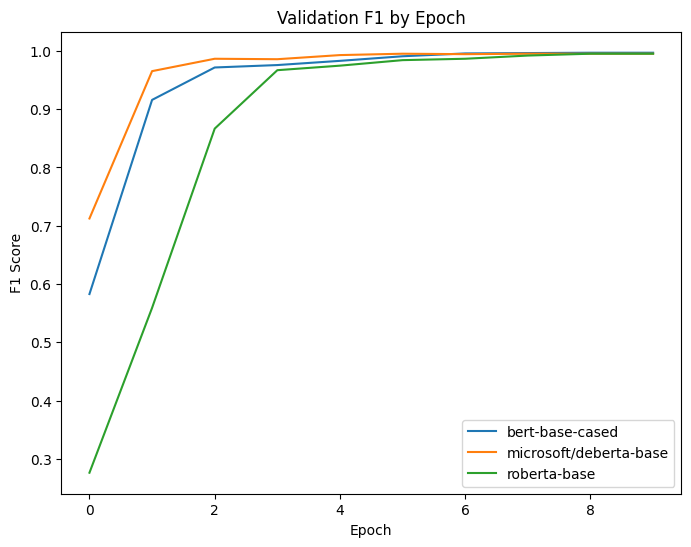

In [ ]:
print("\n======= Final Results =======")
for mname in model_names:
    print(f"\nModel: {mname}")
    print("  Training Loss per epoch:", all_results[mname]["train_loss"])
    print("  Validation Loss per epoch:", all_results[mname]["val_loss"])
    print("  Validation F1 per epoch:", all_results[mname]["val_f1"])

# Plot F1 for each model across epochs
plt.figure(figsize=(8,6))
for mname in model_names:
    plt.plot(all_results[mname]["val_f1"], label=mname)
plt.title("Validation F1 by Epoch")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.legend()
plt.show()

In [ ]:
print(model_names)

['bert-base-cased', 'microsoft/deberta-base', 'roberta-base']


In [ ]:
torch.save(model_names[0], '/content/drive/MyDrive/Projects/vboom/models/bert_full.pth')